# Implementation of the orbit integrations using the BFE method (test case: Hernquist halo)

In [1]:
%pylab inline
import octopus
from pygadgetreader import readsnap
import biff
from scipy import interpolate
from astropy import constants
from astropy import units as u

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


# Code structure:

1. Read Halo particle positions
2. Re-center halo
3. Compute the Snlm and Tnlm coefficients with biff
4. Interpotlate Snlm and Tnlm
5. Use leapfrog with the interpolated coefficients and with biff

# Check 
1. Compare with analytic Hernquist orbit integration
2. Compare with N-body orbit

# To do

1. Check the orbit integration with the analyic orbit
2. Check that the potential from biff and the N-body and the analytic match
3. Fix the time step in octupus.leapfrog.integrate_biff_t to be an input parameter matching the interpolation


# 1. Read Halo particle positions & computing the CM

In [2]:
pos_cm_LMC, vel_cm_LMC, a, b = octopus.orbit('../../data/ICs/LMC/LMC1-97k/', 'LMC1_97K_vir', 0, 100, 97000, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    

In [3]:
rcm_LMC = np.sqrt(pos_cm_LMC[:,0]**2 + pos_cm_LMC[:,1]**2 + pos_cm_LMC[:,2]**2)

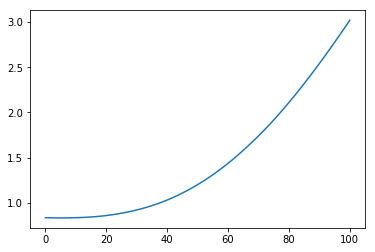

In [4]:
plot(rcm_LMC)

## Core functions:

In [5]:

# Note: CM When the disk is taken into account thew CM should be computed from the CM of the disk
def re_center_halo(pos, r_cm):
    for i in range(3):
        pos[:,i] = pos[:,i] - r_cm[i]
        #vel[:,i] = vel[:,i] - v_cm[i]
    return pos

def compute_coeffs_from_snaps(path, snap_name, N_initial, N_final, Nmax, Lmax):
    """
    Compute the coefficients from a series of snapshots of N-body simulations. 
    Dependecies: pygadgetreader and octopus.
    
    Input:
    ------
    
    path : string
        path to snapshots
    snap_name : string 
        snapshots base name
    N_intitial : int
        initial number of the snapshot.
    N_final : int
        final number of the snaphot in the simulation.
    Nmax : int
        Max number of expansion terms in the radial terms of the BFE.
    Lmax: 
        Max number of expansion terms in the angular terms of the BFE.
        
    Return:
    -------
    
    S : matrix of shape [t, nmax+1, lmax+1, lmax+1]
    T : matrix of shape [t, nmax+1, lmax+1, lmax+1]

    """
    t = N_final - N_initial
    S = np.zeros((t, Nmax+1, Lmax+1, Lmax+1))
    T = np.zeros((t, Nmax+1, Lmax+1, Lmax+1))

    for i in range(N_initial, N_final, 1):
        pos_LMC = readsnap(path+snap_name+'_{:03d}'.format(i), 'pos', 'dm')
        mass_LMC = readsnap(path+snap_name+'_{:03d}'.format(i), 'mass', 'dm')
        rcm, vcm = octopus.CM(pos_LMC,  pos_LMC) # not using velocities!
        pos_LMC_cm = re_center_halo(pos_LMC, rcm)
        S[i], T[i] = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_cm.astype(double)),
                                                  mass_LMC.astype(double)*1E10,
                                                  Nmax, Lmax, 3)
    return S, T


    

path = '../../data/ICs/LMC/LMC1-97k/'
snap_name = 'LMC1_97K_vir'

In [6]:
N_initial = 0
N_final = 10
S_test, T_test = compute_coeffs_from_snaps(path, snap_name, 0, 100, 10, 2)

Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM    Positions
Returning DM    Mass
Returning DM 

In [7]:
def interpolate_coeff(S, T, dt_nbody, dt_int, N_initial, N_final, nmax, lmax):
    """
    Interpolate the BFE coefficients.
    
    Parameters:
    -----------
        Snlm : float 
            The value of the cosine expansion coefficient for the desired number of snapshots to be interpolated.
        Tnlm : float 
            The value of the sine expansion coefficient for the desired number of snapshots to be interpolated.
        dt_nbody : float
            Time bet snapshot in the n-body simulation.
        dt_int : float
            Time 
        N_initial : int
            Inital snapshot number. 
        N_final : int
            Final snapshot number. 
        nmax : 
            Maximum value of ``n`` for the radial expansion.
        lmax : 
            Maximum value of ``l`` for the spherical expansion.
    Returns:
    --------
        Snlm_interpolate : float 
            The value of the cosine expansion coefficient interpolated for different dt values.
        Tnlm_interpolate : float 
            The value of the sine expansion coefficient interpolated for different dt values.
    """

    #dt_int = 0.01
    #dt_nbody = 0.02
    time = (N_final - N_initial) * dt_nbody 

    time_array = np.linspace(0, time, time/dt_nbody)
    time_array_new = np.linspace(0, time, time/dt_int)
    #S_test[:,0,0,0]
    #print(time_array)
    #nmax = 20
    #lmax = 2
    #print(time/dt_nbody)

    S_new = np.zeros((int(time/dt_int), nmax+1, lmax+1, lmax+1))
    T_new = np.zeros((int(time/dt_int), nmax+1, lmax+1, lmax+1))

    for i in range(nmax+1):
        for j in range(lmax+1):
            for k in range(lmax+1):
                if k<=j:
                    # put the contrain k<j ? 
                    f = interpolate.interp1d(time_array, S[:,i,j,k])
                    #print(f(time_array_new))
                    S_new[:,i,j,k] = f(time_array_new)
    #print(S_test[:,0,0,0])
    #print(S_test_new)

    #figure(figsize(7,5))
    return S_new, T_new
    #plot(time_array, S_test[:,15,0,2], '-o')
    #plot(time_array_new, S_new[:,15,0,2], '-o', alpha=0.6)

In [8]:
%time S_interp, T_interp = interpolate_coeff(S_test, T_test, 0.02, 0.001, 0, 100, 10, 2)

CPU times: user 4.61 ms, sys: 4 µs, total: 4.61 ms
Wall time: 4.39 ms


# 5. Use leapfrog with the interpolated coefficients and with biff

In [9]:
import sys
sys.path.insert(0, '../../../BFE_integrator/src/')
import leapfrog_bfe

In [10]:
G = constants.G.to(u.kpc**3 / (u.Msun * u.Gyr**2)).value
print(G)
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun))
M = sum(readsnap(path+snap_name+'_000', 'mass', 'dm')) #* 1E10
r_s = 3
print(M)
t_orb, x_orb, y_orb, z_orb, vx_orb, vy_orb, vz_orb = leapfrog_bfe.integrate_biff_t(10, 0, 0, 0, 200, 0, 2, S_interp, \
                                                                                   T_interp, G_c.value, 1, r_s)

4.499753324353496e-06
Returning DM    Mass
2.99862


In [16]:

t_orb_biff_st, x_orb_biff_st, y_orb_biff_st, z_orb_biff_st, vx_orb_biff_st, vy_orb_biff_st, vz_orb_biff_st = leapfrog_bfe.integrate_biff(10, 0, 0, 0, 200, 0, 2, S_interp[0], \
                                                                                   T_interp[0], 10, 2, G_c.value, M*1E10, r_s)

# 6. Compare with analytic Hernquist.

In [17]:
t_orb_an, x_orb_an, y_orb_an, z_orb_an, vx_orb_an, vy_orb_an, vz_orb_an = leapfrog_bfe.integrate_hern(10, 0, 0, 0, 100,\
                                                                                                      0, 2, M*1E10, r_s)


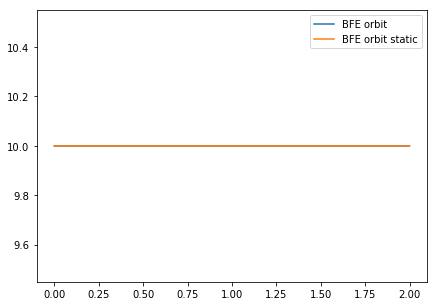

In [24]:
figure(figsize=(7, 5))
plot(t_orb, x_orb, label='BFE orbit')
plot(t_orb_biff_st, x_orb_biff_st, label='BFE orbit static')
#plot(t_orb_an, x_orb_an, label='Analytic')
legend()

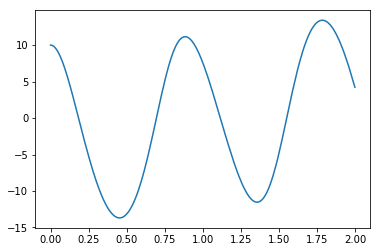

In [15]:
plot(t_orb_an, x_orb_an, label='Analytic')
